In [2]:
import json
import requests
import time
from os import listdir
import numpy as np
import pandas as pd
import datetime
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
% matplotlib inline

In [142]:
! mkdir boligsiden
! mkdir boligsiden/raw_json_pris
! mkdir boligsiden/raw_json_bbr
! mkdir figs

mkdir: cannot create directory ‘boligsiden’: File exists
mkdir: cannot create directory ‘boligsiden/raw_json_pris’: File exists
mkdir: cannot create directory ‘boligsiden/raw_json_bbr’: File exists
mkdir: cannot create directory ‘figs’: File exists


# Scrape data

In [2]:
session = requests.session()
def get(url,iterations=10, ratelimit=0.3):
    for i in range(iterations):
        time.sleep(ratelimit)
        try:
            response = session.get(url)
        except:
            continue
        if response.ok:
            return response
    return None

In [3]:
url = 'https://www.boligsiden.dk/area/getallmunicipalities'
muncis = get(url).json()
muncis_names = [i['encodedName'].lower() for i in muncis]
json.dump(muncis, open('boligsiden/muncis.json','w'))
json.dump(muncis_names, open('boligsiden/muncis_names.json','w'))

In [4]:
def scrape_boligsiden_counts(start, end, muncis) :
    muncis_count = {}
    for munci in muncis:
        url = 'https://www.boligsiden.dk/salespriceresult/getdata?salgspristype=pris&periode.from=%s&periode.to=%s&kommune=%s&boligtype=alle&side=1'%(start,end,munci)
        response = get(url)
        muncis_count[munci] = response.json()['searchResult']['result']['totalCount']
    path = 'boligsiden/muncis_count_%s_%s.json'%(start,end)
    json.dump(muncis_count,open(path,'w'))

In [6]:
scrape_boligsiden_counts('2014-01-01','2018-07-31',['koebenhavn'])

In [7]:
def scrape_boligsiden_sales(start, end, muncis, muncis_count, page_start=1) :
    for munci in muncis :
        print(munci)
        n_results = muncis_count[munci]
        for page_n in range(page_start,int(n_results/30)+2):
            url ='https://www.boligsiden.dk/salespriceresult/getdata?salgspristype=pris&periode.from=%s&periode.to=%s&kommune=%s&boligtype=alle&side=%d'%(start,end,munci,page_n)
            try:
                response = get(url)
            except:
                time.sleep(60)
                response = get(url)
            response_json = response.json()
            path = 'boligsiden/raw_json_pris/pris_%s_%s_%s_%d.json'%(start,end,munci,page_n)
            json.dump(response_json,open(path,'w'))

In [8]:
scrape_boligsiden('pris', '2014-01-01', '2018-07-31', ['koebenhavn'], 
                  json.load(open('boligsiden/muncis_count_pris_2014-01-01_2018-07-31.json','r')))

# Format data

In [5]:
def make_df_sales() :
    base_path = 'boligsiden/raw_json_pris/'
    files = [base_path+i for i in listdir(base_path)]
    data = []
    for filename in files:
        results = json.load(open(filename,'r'))
        for datapoint in results['searchResult']['result']['propertySales']:
            data.append(datapoint)
    return pd.DataFrame(data)

In [6]:
sales = make_df_sales()

In [7]:
sales['type'] = sales['itemTypeName']
sales['res_area'] = sales['residentialArea'].astype(float)
sales['price'] = sales['sales'].apply(lambda l : l[0]['salePrice']).str.replace('.','').astype(float)
sales['price_m2'] = sales['price'] / sales['res_area']
sales['price_m2'] = sales['price_m2'] / 1000
sales['sale_date'] = pd.to_datetime(sales['sales'].apply(lambda l : l[0]['saleDate']), format='%d-%m-%Y')
sales['year'] = sales['sale_date'].apply(lambda d : d.year)
sales['yearseason'] = sales['year'].astype(str) + sales['sale_date'].apply(lambda d : 'S' if (d.month < 7) else 'F')
sales['sale_day'] = (sales['sale_date'] - pd.datetime(1970,1,1)).apply(lambda d : d.days)
sales['sale_type'] = sales['sales'].apply(lambda l : l[0]['saleType'])
sales['coords'] = sales['mapPosition'].apply(lambda d : d['latLng'])
sales['coords'] = [shapely.geometry.Point(p['lng'], p['lat']) for p in sales['coords']]
sales['west_of_harbour'] = sales['city'].isin(['København S', 'Kastrup'])
sales = sales.sort_values(by=['sale_date'])
sales = sales[sales['sale_type']=='Fri handel']
sales = sales.drop(['postal','mapPosition','bbrLink','itemTypeName',
            'residentialArea','sales','soldLink','wishPropertyLocationLink',
            'price','sale_type'], axis=1)
sales = sales.reset_index(drop=True)
sales = gpd.GeoDataFrame(sales, geometry='coords')
sales.crs = {'init': 'epsg:4326'}
sales = sales.to_crs(epsg=32632)
# UTM zones distort dist no more than max 1 meter per 1000 meter. 
#https://www.e-education.psu.edu/natureofgeoinfo/c2_p22.html

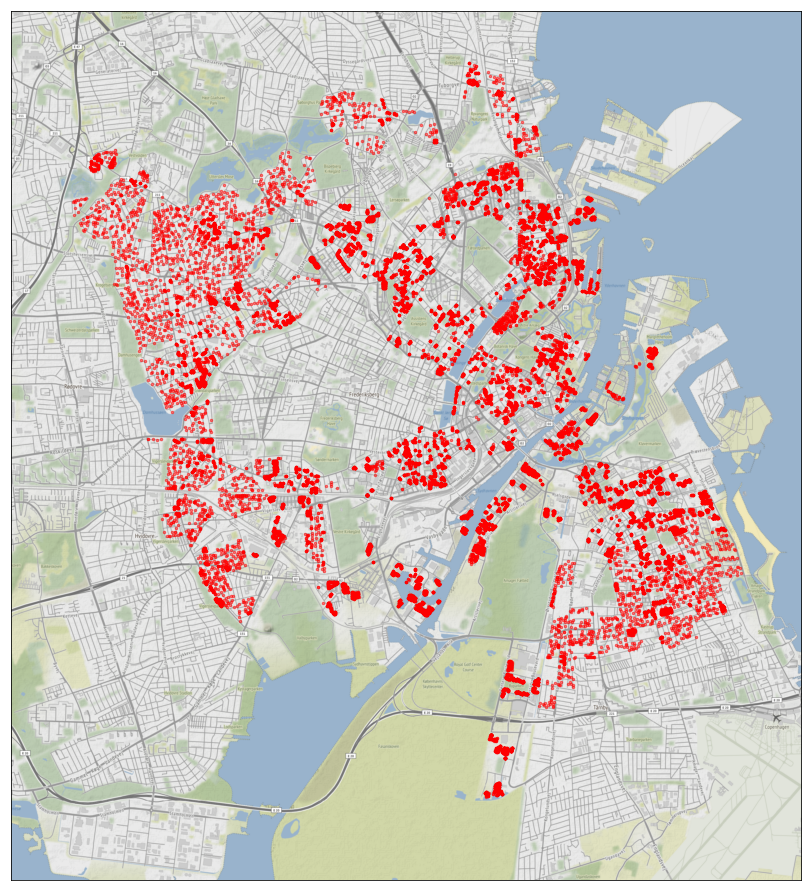

In [59]:
sales_plt = sales.to_crs(epsg=3857).plot(figsize=(20,16), color='red', markersize=6, alpha=0.5)
xmin, xmax, ymin, ymax = sales_plt.axis()
cphmap_sales, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=14, url=ctx.sources.ST_TERRAIN)
sales_plt.imshow(cphmap_sales, extent=extent, interpolation='bilinear')
sales_plt.get_xaxis().set_visible(False)
sales_plt.get_yaxis().set_visible(False)
plt.savefig('figs/map_all_sales.png')

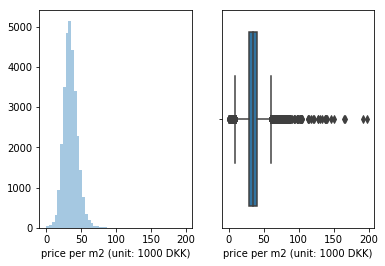

In [8]:
fig, axs = plt.subplots(1,2)
sns.distplot(sales['price_m2'], ax=axs[0], kde=False)
sns.boxplot(sales['price_m2'], ax=axs[1])
for ax in axs : ax.set_xlabel('price per m2 (unit: 1000 DKK)')
fig.savefig('figs/price_dist_all_sales.png')

In [9]:
sales.shape

(30251, 11)

In [10]:
socioeco = gpd.read_file('socioeco.json')
socioeco = socioeco.to_crs(epsg=32632)
socioeco = socioeco[(socioeco['antal_boliger']>0) & (socioeco['antal_beboere']>0)]
merged = gpd.sjoin(sales[['coords','year']], socioeco[['geometry','aar','pct_ikke_vestlig', 'pct_lav_indkomst', 'pct_middel_indkomst', 'pct_hoj_indkomst']], op='within').drop('index_right',axis=1).sort_index()
merged = merged[merged['aar']<=merged['year']].groupby(lambda i : i).mean()
sales = sales.join(merged.drop(['aar','year'],axis=1))
sales = sales.dropna()

In [4]:
sales = sales.reset_index(drop=True)
sales.index.name='s1'

In [5]:
sales.to_pickle('2014-01-01_2018-07-31_koebenhavn_predictive.pkl')

In [12]:
schools = gpd.read_file('school_districts.json')
schools = schools.to_crs(epsg=32632)

In [13]:
schools = schools.drop(['id','bydel'], axis=1)

In [14]:
schools_perf = pd.read_html('skole_kars.html',header=0)[0]
schools_perf = schools_perf.melt(id_vars='skolenavn', var_name='year', value_name='karsnit')
schools_perf['year'] = schools_perf.year.astype(int)
schools_perf['karsnit'] = schools_perf.karsnit / 10
schools_perf = schools_perf.dropna()

In [15]:
schools['karsnit'] = schools.skolenavn.apply(lambda n : schools_perf[schools_perf.skolenavn==n].karsnit.mean())

In [16]:
sales = gpd.sjoin(sales, schools[['skolenavn','geometry']], op='within').drop('index_right',axis=1)

In [17]:
baddistricts = list(schools[schools['karsnit'].isnull()]['skolenavn'])
baddistricts.append('Christianshavns Skole')

In [18]:
sales = sales[~sales['skolenavn'].isin(baddistricts)]

In [19]:
def nn_schools(sale_coord, schools, removedistricts=[]) :
    if (len(removedistricts)>0) :
        schools = schools[~schools['skolenavn'].isin(removedistricts)]
    dists = schools.geometry.distance(sale_coord)
    dists = dists[dists>0]
    nn = schools.loc[dists.idxmin(),]
    return nn['skolenavn']

In [20]:
sales['nn_skolenavn'] = sales['coords'].apply(lambda c : nn_schools(c, schools, removedistricts=baddistricts))

In [21]:
def get_school_perf(r, nn=False) :
    year = r.sale_date.year
    if nn : school = r.nn_skolenavn
    else : school = r.skolenavn
    years = [year-1, year-2]
    df = schools_perf[(schools_perf.skolenavn==school) & (schools_perf.year.isin(years))]
    if (df.shape[0]==0) : 
        years = [year-3, year-4]
        df = schools_perf[(schools_perf.skolenavn==school) & (schools_perf.year.isin(years))]
    if (df.shape[0]==0) : 
        df = schools_perf[(schools_perf.skolenavn==school)]
    return df.karsnit.mean()

In [22]:
sales['skole_karsnit'] = sales.apply(get_school_perf, axis=1)

In [23]:
sales['nn_skole_karsnit'] = sales.apply(lambda r : get_school_perf(r, nn=True), axis=1)

In [24]:
sales['treatment'] = sales['skole_karsnit'] - sales['nn_skole_karsnit']

In [25]:
sales = sales[sales['price_m2']<sales['price_m2'].quantile(0.99)]

In [26]:
sales = sales[sales['price_m2']>sales['price_m2'].quantile(0.01)]

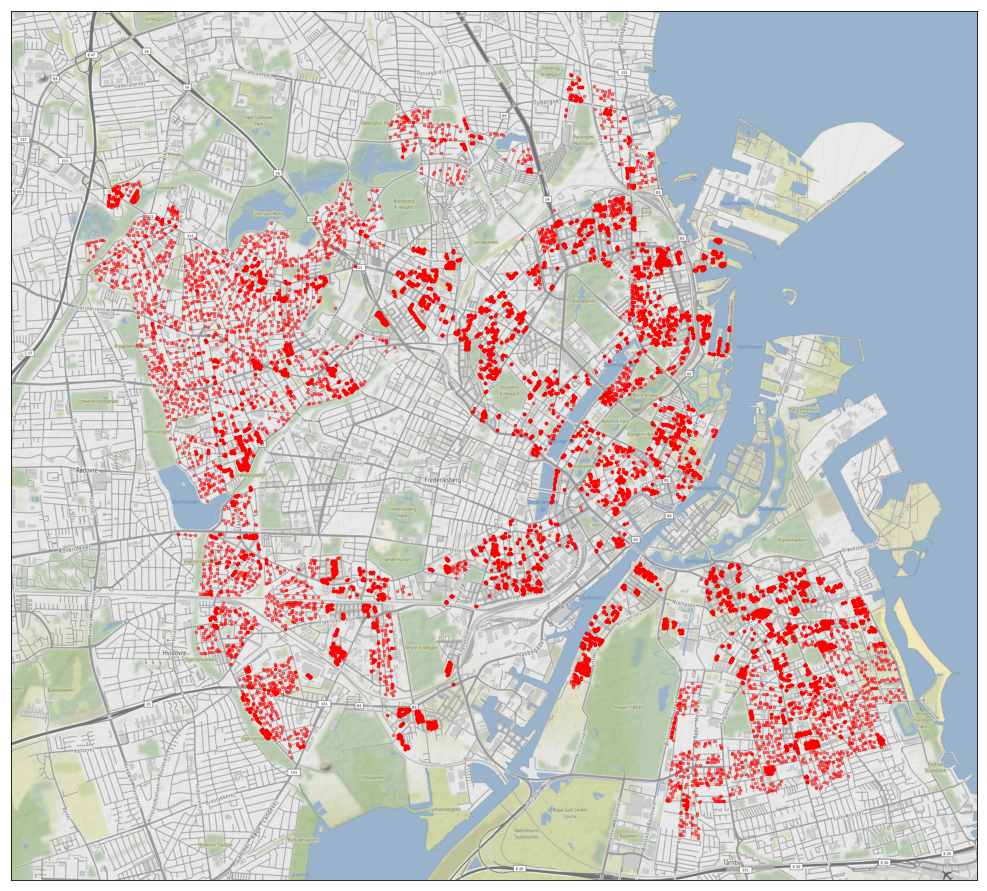

In [121]:
sales_plt = sales.to_crs(epsg=3857).plot(figsize=(20,16), color='red', markersize=6, alpha=0.5)
xmin, xmax, ymin, ymax = sales_plt.axis()
cphmap_sales, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=14, url=ctx.sources.ST_TERRAIN)
sales_plt.imshow(cphmap_sales, extent=extent, interpolation='bilinear')
sales_plt.get_xaxis().set_visible(False)
sales_plt.get_yaxis().set_visible(False)
plt.savefig('figs/map_filtered_sales.png')

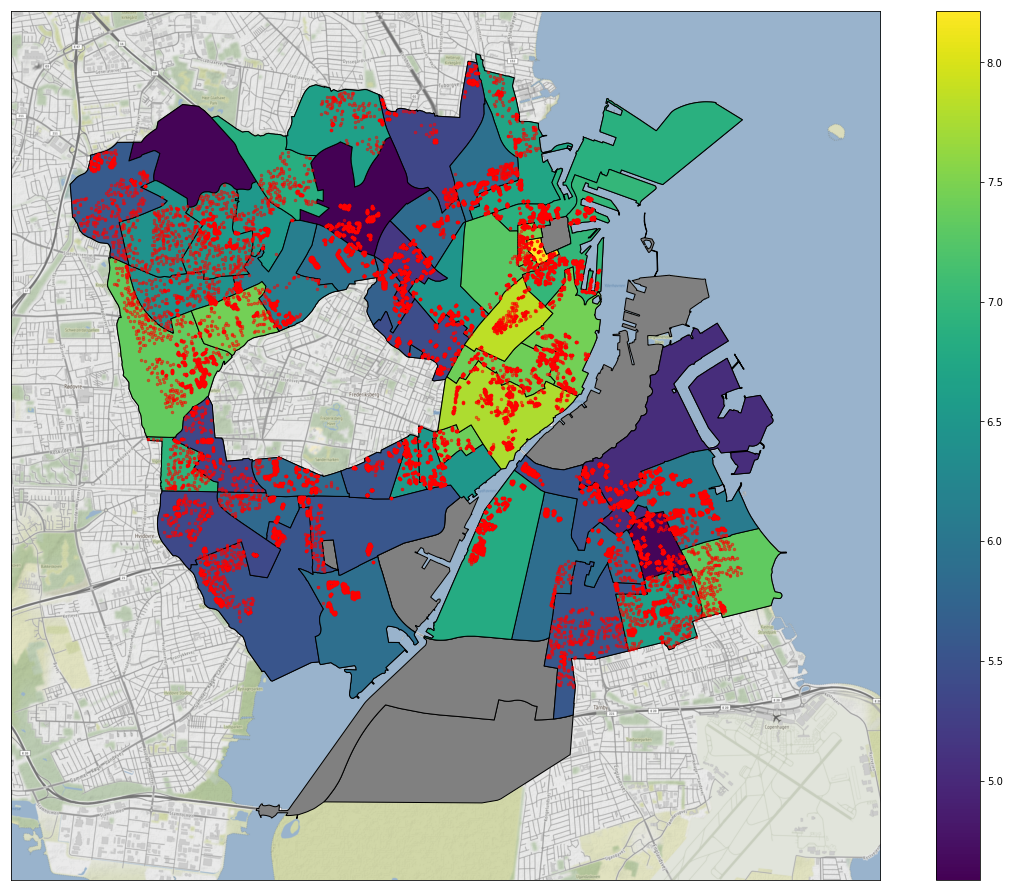

In [122]:
school_plt = schools.to_crs(epsg=3857).plot(figsize=(20,16), color='grey', edgecolor='black')
schools[~schools.skolenavn.isin(baddistricts)].to_crs(epsg=3857).plot(ax=school_plt, column='karsnit', 
                                                          edgecolor='black', legend=True)
sales.to_crs(epsg=3857).plot(ax=school_plt, color='red', markersize=6, alpha=0.5)
xmin, xmax, ymin, ymax = school_plt.axis()
cphmap_school, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=14, url=ctx.sources.ST_TERRAIN)
school_plt.imshow(cphmap_school, extent=extent, interpolation='bilinear')
school_plt.get_xaxis().set_visible(False)
school_plt.get_yaxis().set_visible(False)
plt.savefig('figs/map_sales_on_districts.png')

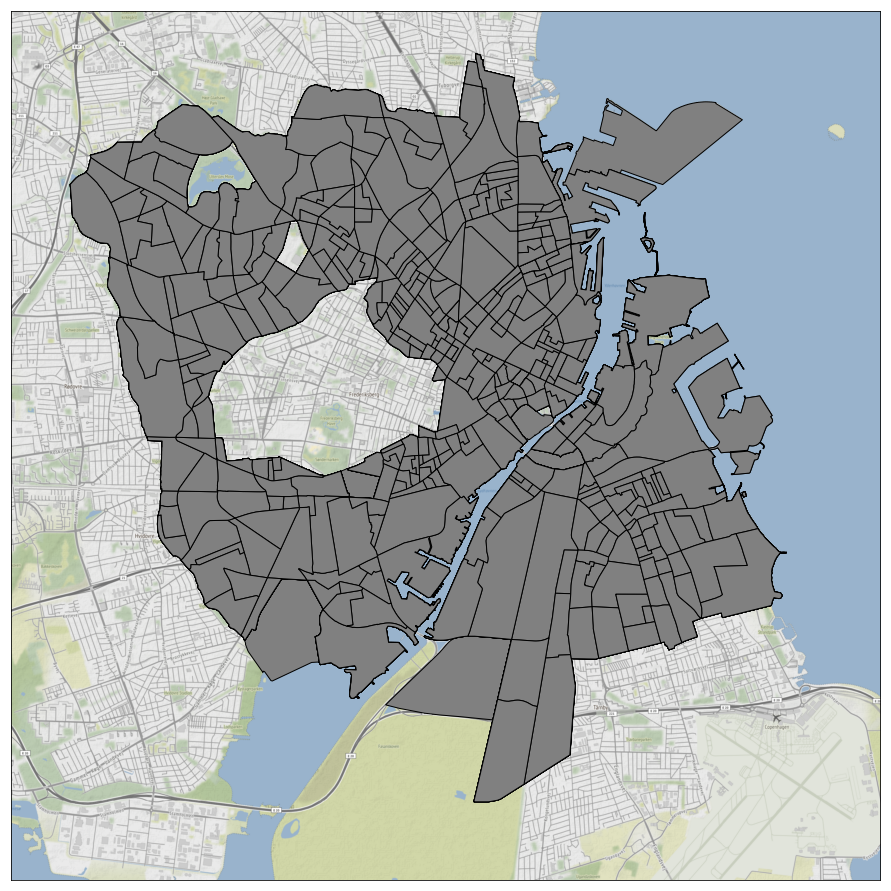

In [82]:
roder_plt = socioeco.to_crs(epsg=3857).plot(figsize=(20,16), color='grey', edgecolor='black')
#schools.to_crs(epsg=3857).plot(ax=roder_plt, figsize=(20,16), color='none', edgecolor='red')
xmin, xmax, ymin, ymax = roder_plt.axis()
cphmap_school, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=14, url=ctx.sources.ST_TERRAIN)
roder_plt.imshow(cphmap_school, extent=extent, interpolation='bilinear')
roder_plt.get_xaxis().set_visible(False)
roder_plt.get_yaxis().set_visible(False)
plt.savefig('figs/map_roder.png')

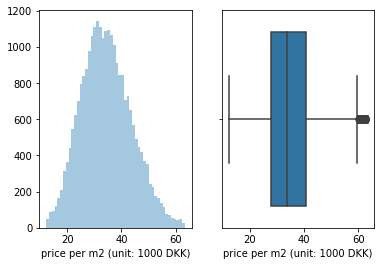

In [27]:
fig, axs = plt.subplots(1,2)
sns.distplot(sales['price_m2'], ax=axs[0], kde=False)
sns.boxplot(sales['price_m2'], ax=axs[1])
for ax in axs : ax.set_xlabel('price per m2 (unit: 1000 DKK)')
fig.savefig('figs/price_dist_filtered_sales.png')

In [28]:
sales = sales.reset_index(drop=True)
sales.index.name='s1'

In [29]:
sales.shape

(25689, 20)

In [30]:
30251 - 25689

4562

In [31]:
sales.to_pickle('2014-01-01_2018-07-31_koebenhavn_causal.pkl')

In [32]:
schools_perf.reset_index(drop=True).to_pickle('schools_perf.pkl')

In [33]:
schools.reset_index(drop=True).to_pickle('schools.pkl')